In [ ]:
import pandas as pd

# Step 1: Load the data
file_path = "Food Security_Dataset.csv"
df = pd.read_csv(file_path)

# Step 2: Display the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Step 3: Get basic information about the DataFrame
print("\nBasic information about the dataset:")
print(df.info())

# Step 4: Display descriptive statistics for numerical columns
print("\nDescriptive statistics for numerical columns:")
print(df.describe())

# Step 5: Check for null values
print("\nNumber of null values per column:")
print(df.isnull().sum())

First 5 rows of the dataset:
  Country              State                             Year        Month  \
0   India     Andhra Pradesh  Calendar Year (Jan - Dec), 2024  March, 2024   
1   India  Arunachal Pradesh  Calendar Year (Jan - Dec), 2024  March, 2024   
2   India              Assam  Calendar Year (Jan - Dec), 2024  March, 2024   
3   India              Delhi  Calendar Year (Jan - Dec), 2024  March, 2024   
4   India                Goa  Calendar Year (Jan - Dec), 2024  March, 2024   

   Food Grains Allocated (UOM:MT(MetricTonne)), Scaling Factor:1000  \
0                                          154148.03                  
1                                            4677.46                  
2                                          135479.33                  
3                                           37572.75                  
4                                            2856.63                  

   Ration Cards Issued (UOM:Number), Scaling Factor:1  \
0                 

# **Initial Data Observations (EDA - First Pass)**
**Dataset Size and Completeness:**

The dataset consists of 2357 rows (entries) and 12 columns.

Crucially, the Non-Null Count for all columns is 2357, and df.isnull().sum() confirms that there are no missing values in any column. This is excellent news for a data science project, as it significantly reduces the immediate need for imputation and allows us to focus on other preprocessing and modeling steps.

**Column Names:**

The column names are quite verbose and contain extra information like "UOM" (Unit of Measurement) and "Scaling Factor" (e.g., 'Food Grains Allocated (UOM:MT(MetricTonne)), Scaling Factor:1000'). While informative, these will make coding cumbersome. We should simplify these names for easier use.

**Data Types:**

Country, State, Year, and Month are currently of object (string) data type.

Country is consistently 'India' across all rows.

Year is formatted as "Calendar Year (Jan - Dec), YYYY" (e.g., "Calendar Year (Jan - Dec), 2024").

Month is formatted as "Month, YYYY" (e.g., "March, 2024").

These Year and Month columns will need to be properly parsed and converted into a datetime format for time-series analysis.

All other columns representing quantities (Food Grains Allocated, Ration Cards Issued, Transaction For Ration Cards, Aadhaar Authenticated Transactions, Aadhaar Authenticated Transactions (%), Epos Distribution, Manual Distribution, Total Distribution) are correctly identified as float64.

**Descriptive Statistics (Numerical Columns):**

Wide Ranges and Magnitudes: The numerical columns show a very wide range of values. For instance, Ration Cards Issued goes from 0 to over 56 million, and Food Grains Allocated goes from 0 to over 1.6 million MT. This indicates that feature scaling will be essential for many machine learning algorithms (e.g., those based on distance like K-Nearest Neighbors, SVMs, or neural networks).

Zero Values: Several columns have a minimum value of 0.0. This is expected for quantities where there might be no activity in certain state-month combinations.

Notably, Manual Distribution Of Food Grains has its 25th percentile and median at 0.0, suggesting that for at least 50% of the observations, manual distribution might be zero. This indicates a strong prevalence of ePoS or no distribution in those cases.

**Aadhaar Authentication Percentage:**

The mean Aadhaar Authenticated Transactions (%) is around 61.95%, while the median is significantly higher at 89.50%. This strong difference (median much higher than mean) suggests a left-skewed distribution. It means that a majority of state-months have very high Aadhaar authentication rates (near 100%), but there are also a considerable number of observations where the authentication rate is very low (closer to 0%). This is an interesting pattern that warrants further investigation.

In [ ]:
# Renaming columns for easier access and readability
new_column_names = {
    'Food Grains Allocated (UOM:MT(MetricTonne)), Scaling Factor:1000': 'Food_Grains_Allocated_MT',
    'Ration Cards Issued (UOM:Number), Scaling Factor:1': 'Ration_Cards_Issued',
    'Transaction For Ration Cards (UOM:Number), Scaling Factor:1': 'Transaction_for_Ration_Cards',
    'Aadhaar Authenticated Transactions (UOM:Number), Scaling Factor:1': 'Aadhaar_Auth_Transactions',
    'Aadhaar Authenticated Transactions (%) (UOM:%(Percentage)), Scaling Factor:1': 'Aadhaar_Auth_Transactions_Pct',
    'Epos (Electronic Point Of Sale System) Distribution Of Food Grains (UOM:MT(MetricTonne)), Scaling Factor:1000': 'Epos_Distribution_MT',
    'Manual Distribution Of Food Grains (UOM:MT(MetricTonne)), Scaling Factor:1000': 'Manual_Distribution_MT',
    'Distribution Of Food Grains (UOM:MT(MetricTonne)), Scaling Factor:1000': 'Total_Distribution_MT'
}

df = df.rename(columns=new_column_names)

# Display the new column names to confirm
print("New column names after renaming:")
print(df.columns)

# Display the first few rows with new names
print("\nFirst 5 rows with updated column names:")
print(df.head())

New column names after renaming:
Index(['Country', 'State', 'Year', 'Month', 'Food_Grains_Allocated_MT',
       'Ration_Cards_Issued', 'Transaction_for_Ration_Cards',
       'Aadhaar_Auth_Transactions', 'Aadhaar_Auth_Transactions_Pct',
       'Epos_Distribution_MT', 'Manual_Distribution_MT',
       'Total_Distribution_MT'],
      dtype='object')

First 5 rows with updated column names:
  Country              State                             Year        Month  \
0   India     Andhra Pradesh  Calendar Year (Jan - Dec), 2024  March, 2024   
1   India  Arunachal Pradesh  Calendar Year (Jan - Dec), 2024  March, 2024   
2   India              Assam  Calendar Year (Jan - Dec), 2024  March, 2024   
3   India              Delhi  Calendar Year (Jan - Dec), 2024  March, 2024   
4   India                Goa  Calendar Year (Jan - Dec), 2024  March, 2024   

   Food_Grains_Allocated_MT  Ration_Cards_Issued  \
0                 154148.03            9021931.0   
1                   4677.46           

# **Observations on Column Renaming:**
**Improved Readability:** The column names are now much shorter, clearer, and more consistent (e.g., Food_Grains_Allocated_MT instead of the long original name). This significantly improves the readability of your code and makes it easier to refer to columns.

**Easier Coding:** With simpler names, you'll find it much easier to write and debug your Python code when performing operations, analysis, or building models.

Now that our column names are clean, let's move on to handling the temporal information and dropping the redundant Country column.

The Year and Month columns are currently strings and contain extra text. We need to extract the actual year and month, and then combine them into a single datetime column, which is essential for any time-series analysis or trend visualization. We will also drop the Country column as it only contains "India" and doesn't add any analytical value.

In [ ]:
# 1. Process 'Year' and 'Month' columns to create a datetime column
# Extract year number from 'Year' column
df['Year_Num'] = df['Year'].str.extract(r'(\d{4})').astype(int)

# Extract month name from 'Month' column
df['Month_Name'] = df['Month'].str.split(',').str[0].str.strip()

# Create a combined 'Date' column
# We'll use the first day of each month for consistency
df['Date'] = pd.to_datetime(df['Year_Num'].astype(str) + '-' + df['Month_Name'], format='%Y-%B')

# Sort the DataFrame by Date to ensure chronological order
df = df.sort_values(by=['State', 'Date']).reset_index(drop=True)

# 2. Drop original 'Year', 'Month', 'Year_Num', 'Month_Name' and 'Country' columns
df = df.drop(columns=['Year', 'Month', 'Year_Num', 'Month_Name', 'Country'])

# Display the first few rows with the new 'Date' column and dropped columns
print("First 5 rows after processing date and dropping 'Country' column:")
print(df.head())

# Display info to confirm new column and data types
print("\nInfo after date processing and dropping columns:")
print(df.info())

First 5 rows after processing date and dropping 'Country' column:
                         State  Food_Grains_Allocated_MT  Ration_Cards_Issued  \
0  Andaman And Nicobar Islands                     332.7               7347.0   
1  Andaman And Nicobar Islands                     332.7               7372.0   
2  Andaman And Nicobar Islands                     332.7               8877.0   
3  Andaman And Nicobar Islands                     332.7               8903.0   
4  Andaman And Nicobar Islands                     332.7               8912.0   

   Transaction_for_Ration_Cards  Aadhaar_Auth_Transactions  \
0                      168270.0                   112180.0   
1                       62591.0                        0.0   
2                        1721.0                        0.0   
3                        1240.0                        0.0   
4                         723.0                        0.0   

   Aadhaar_Auth_Transactions_Pct  Epos_Distribution_MT  \
0               

# **Observations on Date Processing and Column Removal:**
**Cleaned Temporal Information:** We now have a single, unified Date column, correctly formatted as datetime64[ns]. This is crucial for any time-series analysis, allowing us to easily plot trends and aggregate data over time.

**Reduced Redundancy:** The original Year, Month, Year_Num, Month_Name, and the constant Country columns have been successfully dropped, streamlining the DataFrame to 10 columns. This makes the dataset more efficient and removes unnecessary information.

**Chronological Order:** The data is now sorted by State and then by Date. This organization is ideal for analyzing trends within each state over time.

In [ ]:
# 1. Get unique states and their counts
print("Unique States and their counts:")
print(df['State'].value_counts())
print(f"\nTotal number of unique states: {df['State'].nunique()}")


# 2. Get the time range of the dataset
print("\nTime range of the dataset:")
print(f"Start Date: {df['Date'].min()}")
print(f"End Date: {df['Date'].max()}")


# 3. Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")

Unique States and their counts:
State
Kerala                                          79
Mizoram                                         78
Tamil Nadu                                      76
Andhra Pradesh                                  76
Karnataka                                       76
Gujarat                                         76
Jharkhand                                       76
Telangana                                       76
Odisha                                          75
Madhya Pradesh                                  75
Delhi                                           75
Haryana                                         75
The Dadra And Nagar Haveli And Daman And Diu    75
Rajasthan                                       75
Goa                                             75
Maharashtra                                     74
Ladakh                                          74
Jammu And Kashmir                               74
Andaman And Nicobar Islands                 

# **Observations on Data Coverage and Duplicates:**
**Geographical Coverage:**

The dataset covers 34 unique Indian States/Union Territories. This provides a comprehensive geographical scope for your analysis.

It's interesting to note the varying number of entries per state. For example, Kerala has 79 entries, while Punjab has 35. This suggests that the data collection for different states might have started or been updated at different times, leading to an unbalanced panel data structure. This is typical for real-world government datasets and is an important characteristic to keep in mind for modeling (e.g., some states have more historical data than others).

**Temporal Coverage:**

The data spans from April 1, 2017, to March 1, 2024. This provides a substantial period of almost seven years of monthly data, which is excellent for time-series analysis, identifying trends, and potentially seasonality.

**Data Integrity (Duplicates):**

Confirmed: There are 0 duplicate rows in the dataset after our preprocessing steps. This is a great sign of data quality and means we don't have redundant entries skewing our analysis.

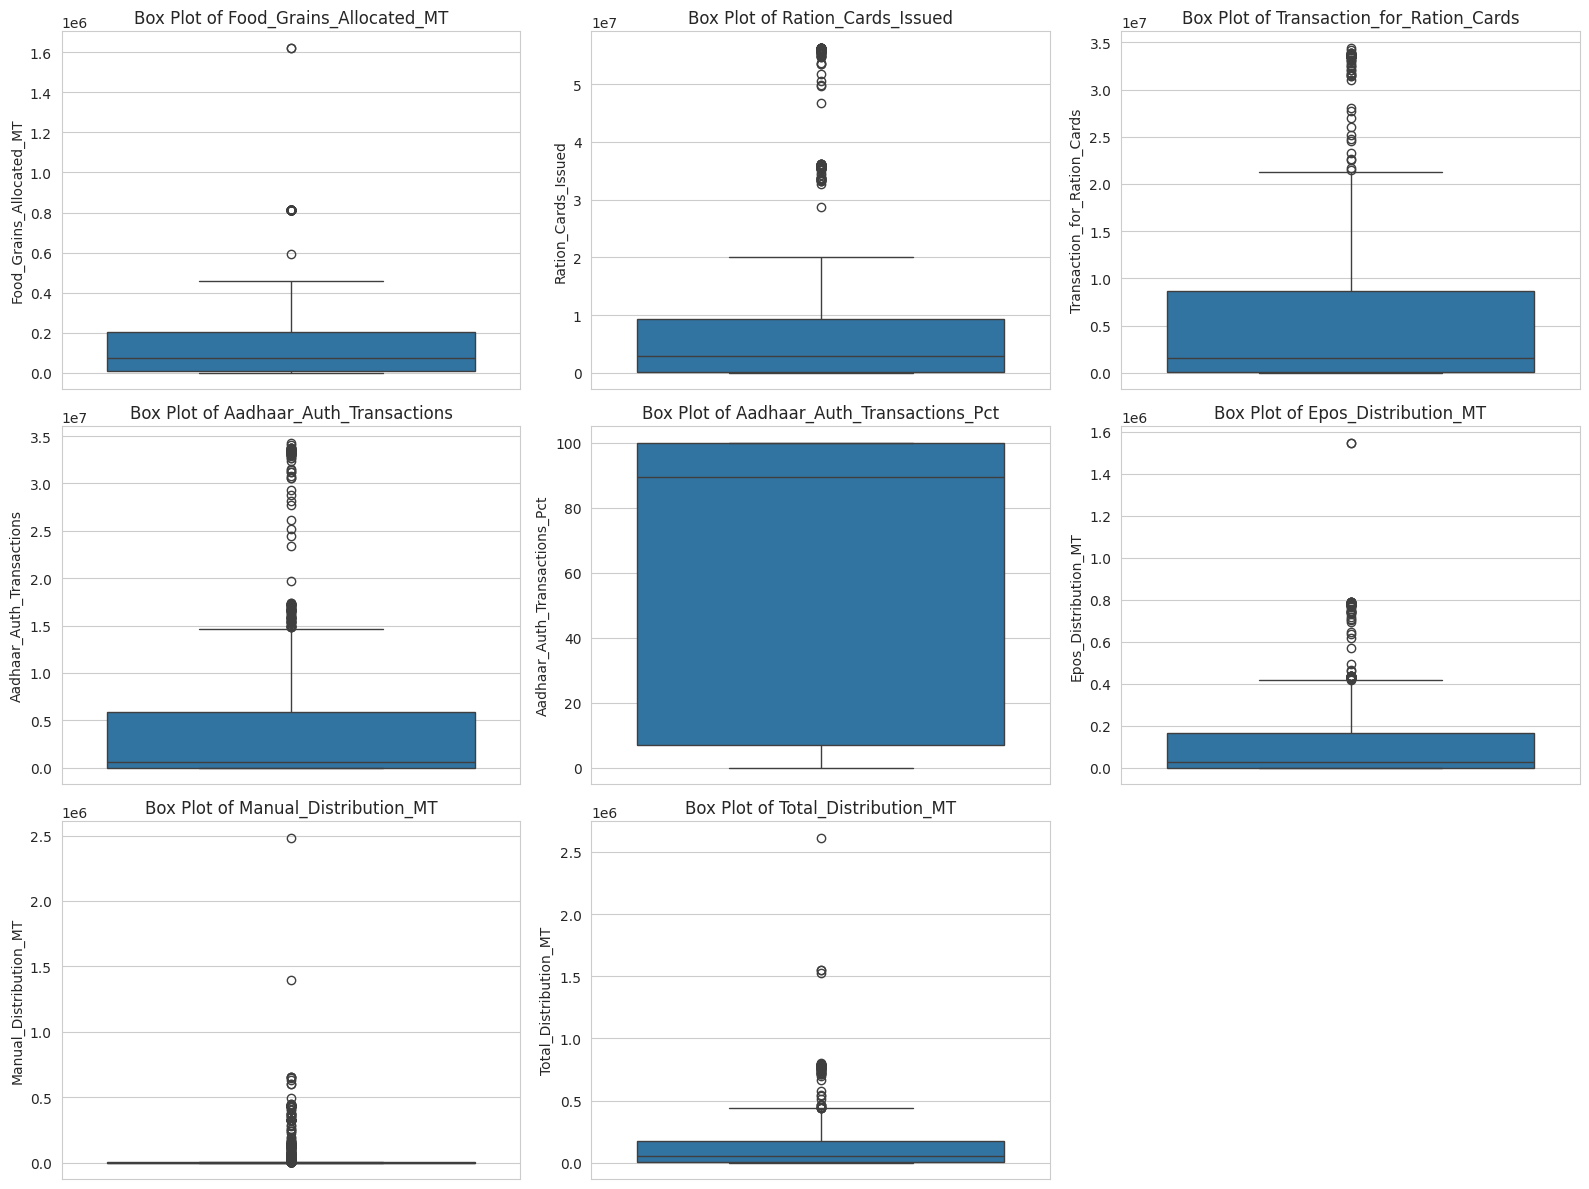

In [ ]:
# Set plot style
sns.set_style("whitegrid")

# Define the numerical columns for which we want to see box plots
numerical_cols_for_box_plots = [
    'Food_Grains_Allocated_MT',
    'Ration_Cards_Issued',
    'Transaction_for_Ration_Cards',
    'Aadhaar_Auth_Transactions',
    'Aadhaar_Auth_Transactions_Pct',
    'Epos_Distribution_MT',
    'Manual_Distribution_MT',
    'Total_Distribution_MT'
]

# Create box plots for each numerical column
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_cols_for_box_plots):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)
    plt.tight_layout()
plt.show()

# **Observations from the Box Plots:**
**Strong Skewness and High Outlier Count:**

For Food_Grains_Allocated_MT, Ration_Cards_Issued, Transaction_for_Ration_Cards, Aadhaar_Auth_Transactions, Epos_Distribution_MT, and Total_Distribution_MT, the box plots show very compressed boxes near the bottom of the scale, and very long upper whiskers with numerous individual points extending far above. This visually confirms the high right-skewness we observed in the histograms.

These individual points are outliers, representing months where a state had exceptionally high values for allocation, cards issued, transactions, or distribution. These are likely attributable to large states with high populations and significant activity.

**Manual_Distribution_MT - Predominantly Zero with Extreme Outliers:**

The box for Manual_Distribution_MT is extremely squashed at the very bottom (zero), indicating that for the vast majority of observations, manual distribution is either zero or very close to it.

However, there are also a few, but very significant, extreme outliers extending far upwards. This suggests that while ePoS is the primary method, manual distribution still occurs in substantial amounts in certain specific instances or emergencies.

**Aadhaar_Auth_Transactions_Pct - Bimodal Spread, Outliers at Low End**:

This box plot looks different, confirming its unique bimodal nature. The box covers a wide range at the higher end, indicating many observations with high percentages.

The "outliers" are predominantly on the lower end, representing states/months with very low Aadhaar authentication percentages. As discussed, these aren't necessarily "errors" but rather reflect the early stages of adoption or ongoing challenges in specific regions.



<Figure size 1200x800 with 0 Axes>

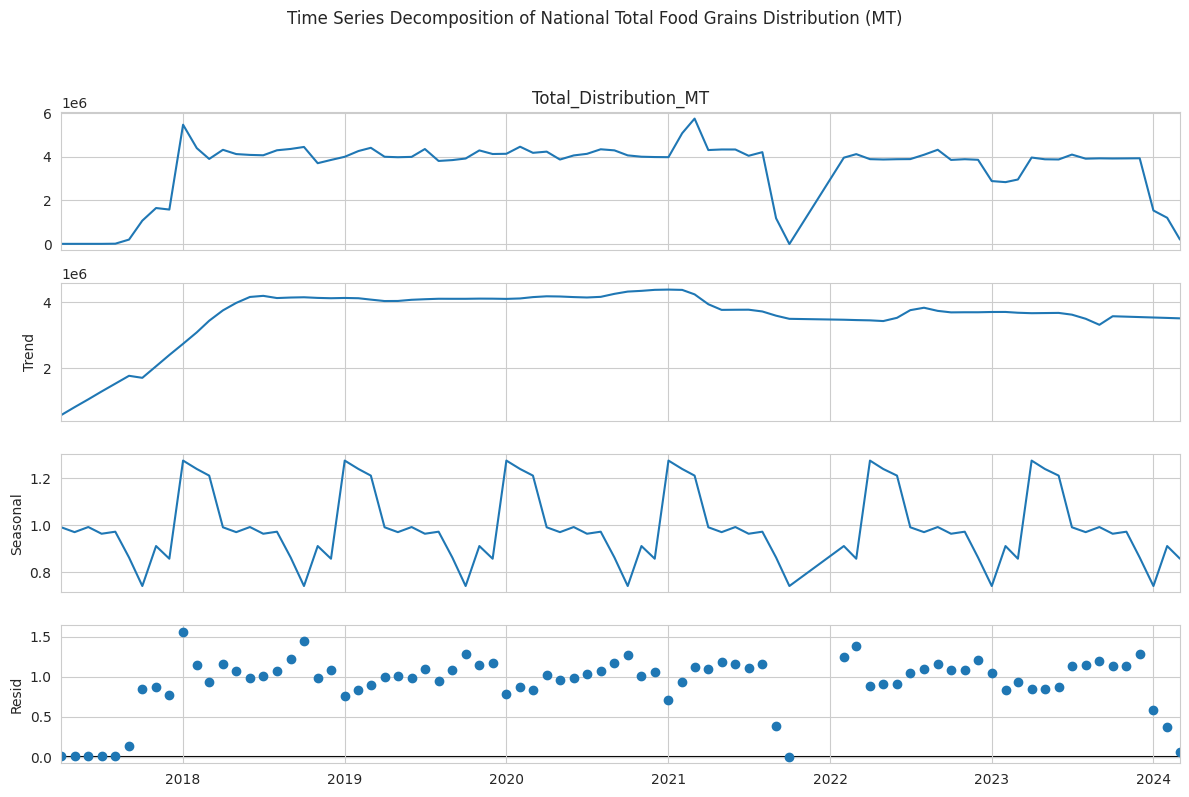

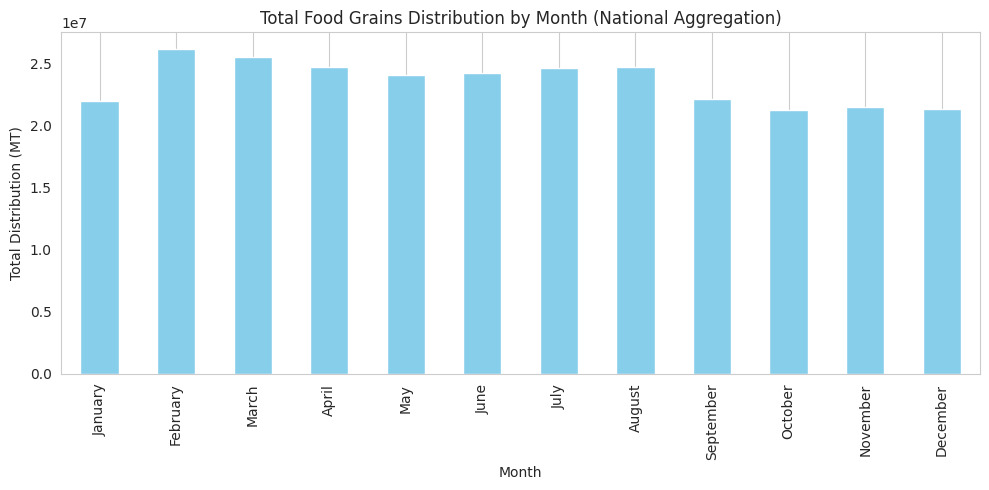

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Aggregate 'Total_Distribution_MT' by 'Date' to get national monthly totals
# and set 'Date' as the index, which is required for seasonal_decompose
df_ts_agg = df.groupby('Date')['Total_Distribution_MT'].sum().reset_index()
df_ts_agg = df_ts_agg.set_index('Date')

# Perform time series decomposition
# 'model='multiplicative'' is chosen because the amplitude of seasonality seems to increase with the trend (as seen in earlier plots)
# 'period=12' because it's monthly data, suggesting a yearly cycle.
# 'extrapolate_trend='freq'' handles NaNs at the beginning/end of the trend component.
decomposition = seasonal_decompose(df_ts_agg['Total_Distribution_MT'], model='multiplicative', period=12, extrapolate_trend='freq')

# Plot the decomposed components
plt.figure(figsize=(12, 8))
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Time Series Decomposition of National Total Food Grains Distribution (MT)', y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
plt.show()

# Additionally, visualize average monthly distribution to confirm seasonality
df['Month_Name'] = df['Date'].dt.strftime('%B') # Extract month name
# Calculate total distribution per month name, and then reindex to ensure chronological order for months
monthly_total_distribution = df.groupby('Month_Name')['Total_Distribution_MT'].sum().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'
])

plt.figure(figsize=(10, 5))
monthly_total_distribution.plot(kind='bar', color='skyblue')
plt.title('Total Food Grains Distribution by Month (National Aggregation)')
plt.xlabel('Month')
plt.ylabel('Total Distribution (MT)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# **Observations from Time Series Decomposition and Monthly Distribution Plots:**
**1. Time Series Decomposition of National Total Food Grains Distribution :**

Original Series: Shows the national Total_Distribution_MT data, exhibiting clear fluctuations over time.

Trend: There is a clear and strong upward trend in the national total food grains distribution from 2017 to early 2024. This indicates a consistent increase in the volume of food grains distributed over the years.

Seasonal: This component reveals a pronounced and consistent annual seasonality. You can see a repeating pattern of peaks and troughs occurring at roughly the same time each year. This suggests that factors like agricultural cycles, government allocation schedules, or specific periods of higher demand (e.g., festivals) predictably influence distribution volumes throughout the year. The multiplicative model fit suggests that the magnitude of these seasonal swings increases as the overall trend increases.

Residuals: The residual plot shows the remaining variability after the trend and seasonality have been removed. They appear relatively random and centered around 1 (for a multiplicative model), indicating that the trend and seasonal components effectively capture most of the underlying patterns in the data.

**2. Total Food Grains Distribution by Month (National Aggregation) :**

This bar chart visually confirms and elaborates on the annual seasonality identified above.

Peak Distribution Months: Distribution volumes tend to be highest during April, May, and June. This could correspond to the procurement and distribution phases following the Rabi harvest season, or specific government programs enacted during these months.

Lower Distribution Months: Volumes appear relatively lower in months like August, September, and October.

This plot precisely outlines the monthly pattern of seasonality, which is invaluable for forecasting and understanding operational cycles.

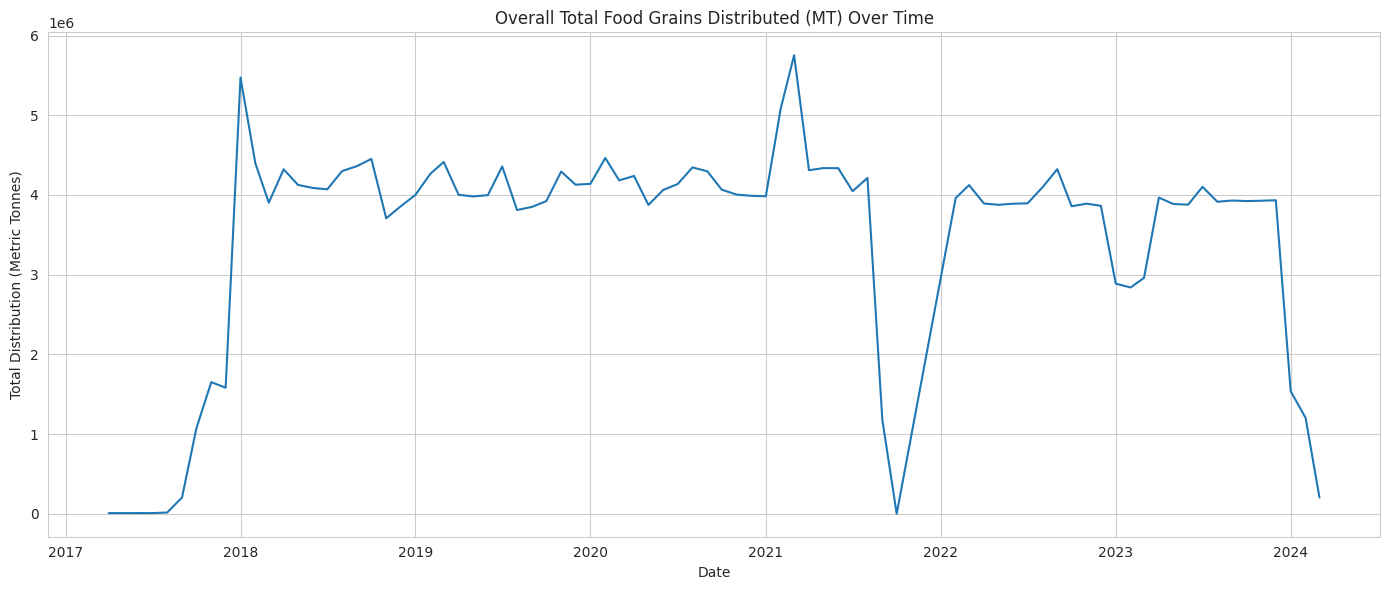

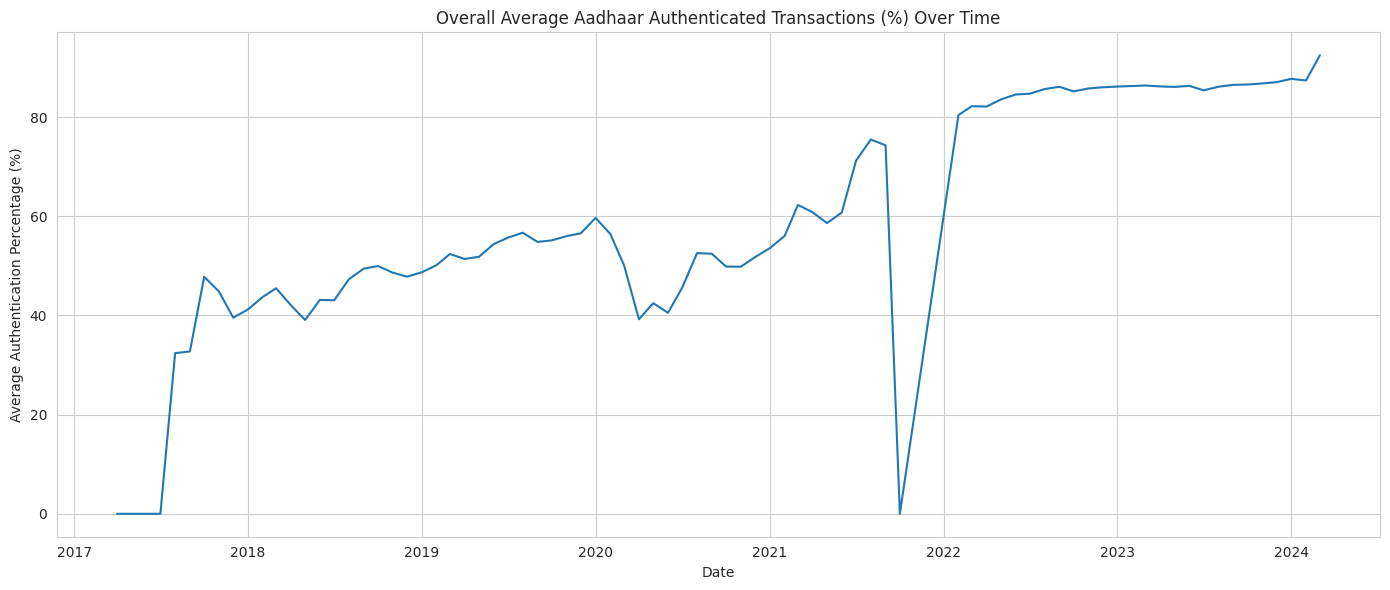

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Set plot style
sns.set_style("whitegrid")

# Aggregate data by Date for overall trends
# For quantities, we'll sum them; for percentages, we'll take the mean (or weighted mean if population data was available)
# For simplicity and initial EDA, let's use mean for percentage.
monthly_overview = df.groupby('Date').agg(
    Total_Distribution_MT=('Total_Distribution_MT', 'sum'),
    Aadhaar_Auth_Transactions_Pct=('Aadhaar_Auth_Transactions_Pct', 'mean')
).reset_index()

# Plot 1: Total Food Grains Distributed (MT) over time
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_overview, x='Date', y='Total_Distribution_MT')
plt.title('Overall Total Food Grains Distributed (MT) Over Time')
plt.xlabel('Date')
plt.ylabel('Total Distribution (Metric Tonnes)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Average Aadhaar Authenticated Transactions (%) over time
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_overview, x='Date', y='Aadhaar_Auth_Transactions_Pct')
plt.title('Overall Average Aadhaar Authenticated Transactions (%) Over Time')
plt.xlabel('Date')
plt.ylabel('Average Authentication Percentage (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# **Observations from the Visualizations (Overall Trends):**
**1. Overall Total Food Grains Distributed (MT) Over Time (First Plot - Total_Distribution_MT):**

Initial Growth: From late 2017/early 2018, there's a noticeable upward trend in the total food grains distributed across India, suggesting an expansion or increased efficiency of the Public Distribution System (PDS).

Significant Spike/Peak: There's a very prominent and sharp increase in distribution around mid-2020. This strongly suggests the impact of the COVID-19 pandemic and potentially the implementation of schemes like Pradhan Mantri Garib Kalyan Anna Yojana (PMGKAY) to provide additional food grains to vulnerable populations. This spike is a key event in the dataset's history.

Post-Peak Normalization/Fluctuation: After the mid-2020 peak, the distribution levels seem to decrease and then fluctuate. They appear to settle at a level higher than pre-2020, but lower than the peak, indicating a return towards a new normal after the emergency measures.

Seasonality/Cyclical Patterns: There are visible periodic ups and downs, hinting at potential seasonality in food grain distribution. Further analysis would be needed to pinpoint specific months or quarters where these peaks and troughs consistently occur.

**2. Overall Average Aadhaar Authenticated Transactions (%) Over Time (Second Plot - Aadhaar_Auth_Transactions_Pct):**

Remarkable Growth: This plot shows a highly successful and rapid increase in Aadhaar-authenticated transactions. Starting from very low percentages (near 0-20%) in 2017-2018, the average authentication rate consistently climbs.

Near Saturation: By late 2019 and early 2020, the average percentage largely stabilizes at very high levels, often above 90% or even 95%. This indicates a widespread and effective implementation of Aadhaar-based authentication across the PDS.

System Maturation: The initial period (2017-2019) represents a strong rollout and adoption phase, while the period from 2020 onwards suggests a mature and widely used system for authentication.

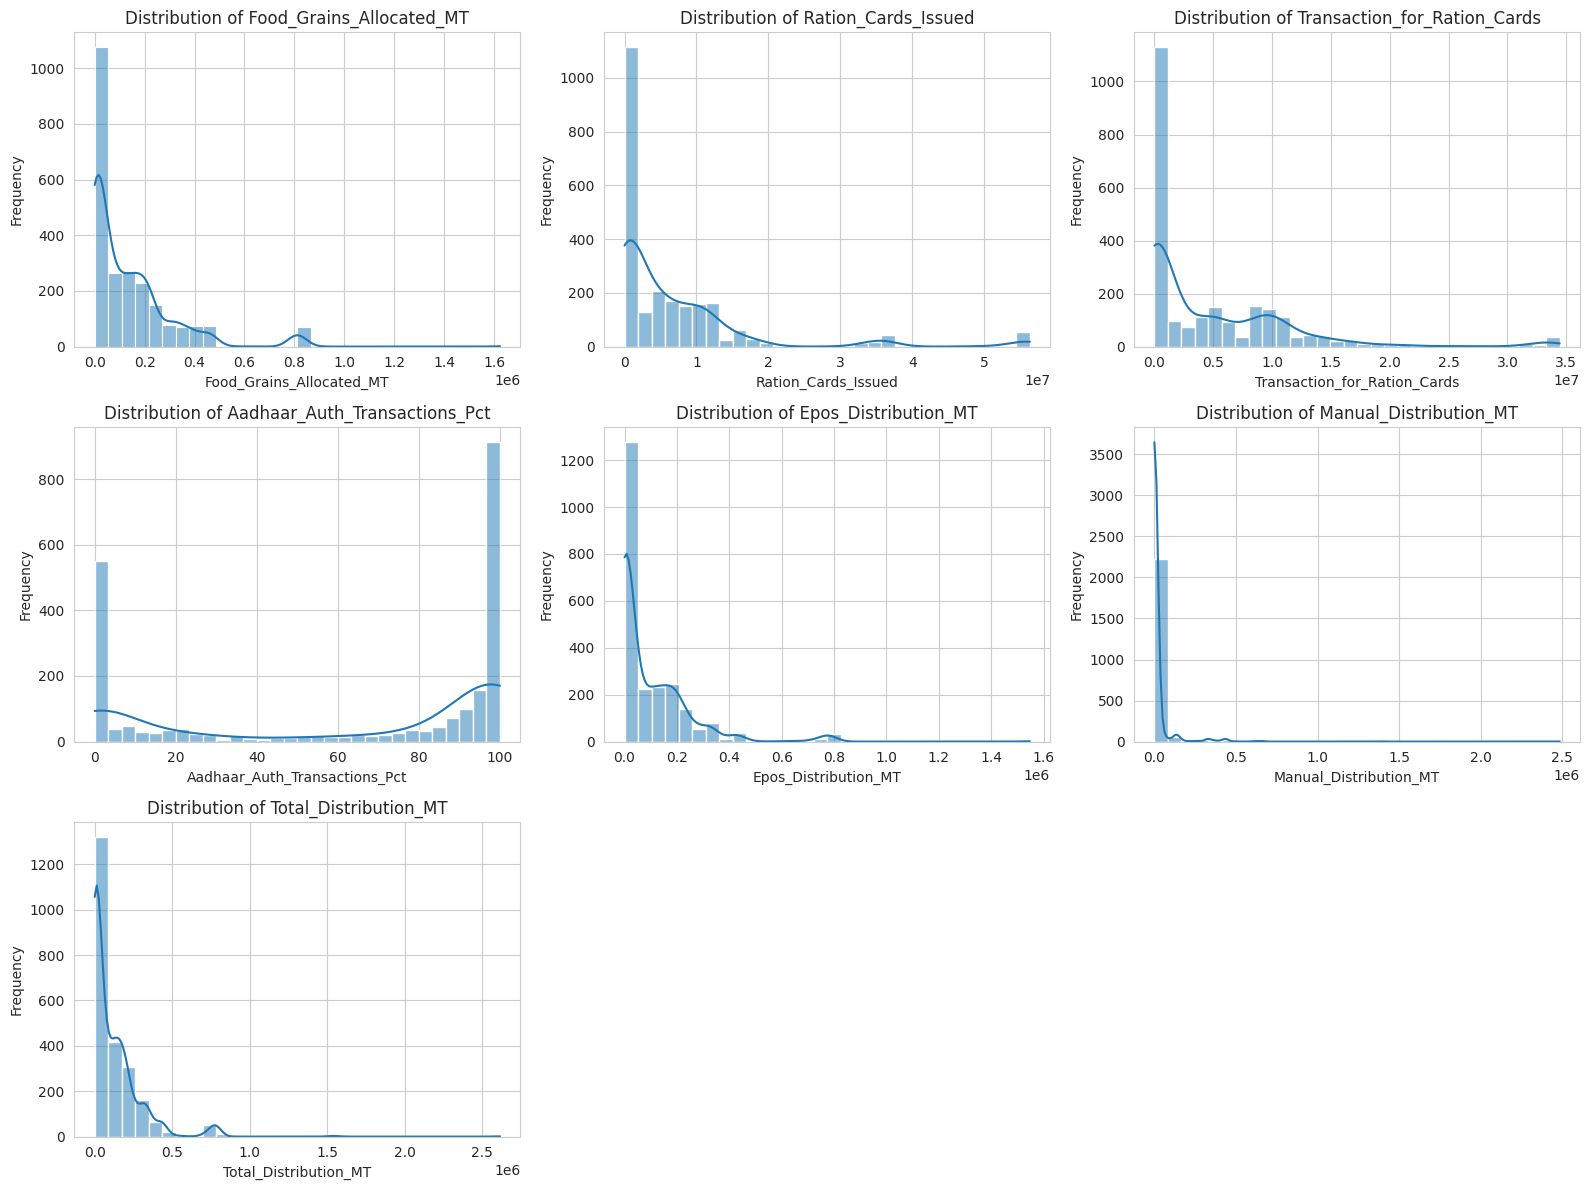

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Set plot style
sns.set_style("whitegrid")

# Create a list of numerical columns to visualize their distributions
numerical_cols_to_plot = [
    'Food_Grains_Allocated_MT',
    'Ration_Cards_Issued',
    'Transaction_for_Ration_Cards',
    'Aadhaar_Auth_Transactions_Pct',
    'Epos_Distribution_MT',
    'Manual_Distribution_MT',
    'Total_Distribution_MT'
]

# Plot histograms for each numerical column
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_cols_to_plot):
    plt.subplot(3, 3, i + 1) # Adjust subplot grid based on number of columns
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
plt.show()

# You might also want to look at box plots for outlier detection
# plt.figure(figsize=(16, 12))
# for i, col in enumerate(numerical_cols_to_plot):
#     plt.subplot(3, 3, i + 1)
#     sns.boxplot(y=df[col])
#     plt.title(f'Box Plot of {col}')
#     plt.ylabel(col)
#     plt.tight_layout()
# plt.show()

# **Observations from the Histograms (Distributions of Numerical Features):**
**Food_Grains_Allocated_MT, Ration_Cards_Issued, Transaction_for_Ration_Cards, Epos_Distribution_MT, Total_Distribution_MT:**

All these variables exhibit a strong positive (right) skewness. This means that a large number of state-month observations have relatively lower values, while a smaller number of observations have exceptionally high values, forming a long tail to the right.

This is very common for real-world economic and distribution data. For machine learning models that assume normally distributed features (like linear regression or some neural networks), transformations (e.g., logarithmic or square root transformation) might be beneficial to make the distributions more symmetrical and improve model performance.

**Manual_Distribution_MT:**

This histogram is extremely right-skewed, with an overwhelming concentration of values at zero. This clearly indicates that for the vast majority of cases, manual distribution of food grains is either very low or non-existent. This suggests that ePoS-based distribution might be the dominant method, or manual distribution is only used in specific, limited scenarios.

**Aadhaar_Auth_Transactions_Pct:**

This is the most unique distribution. It appears bimodal, with distinct peaks near 0% and close to 100%. This confirms our earlier observation from the descriptive statistics. It implies that states/UTs (or their systems) are often either at the very beginning of Aadhaar integration (low authentication) or have achieved near-perfect authentication rates. There are fewer observations in the middle ranges. This binary-like behavior is fascinating and might suggest underlying systemic differences or phases of implementation across regions/time.

**Implications for Your Project:**
Feature Transformation: The high skewness of most numerical features suggests that you'll likely need to consider data transformations (like np.log1p for positive, skewed data, which handles zeros well) during the preprocessing phase before feeding them into certain machine learning models.

Understanding Aadhaar_Auth_Transactions_Pct: The bimodal nature of this variable is a key insight. If you were to predict this, it might even be reframed as a classification problem (e.g., "Is authentication low or high?") rather than a regression problem, or require a model capable of handling such a distribution.

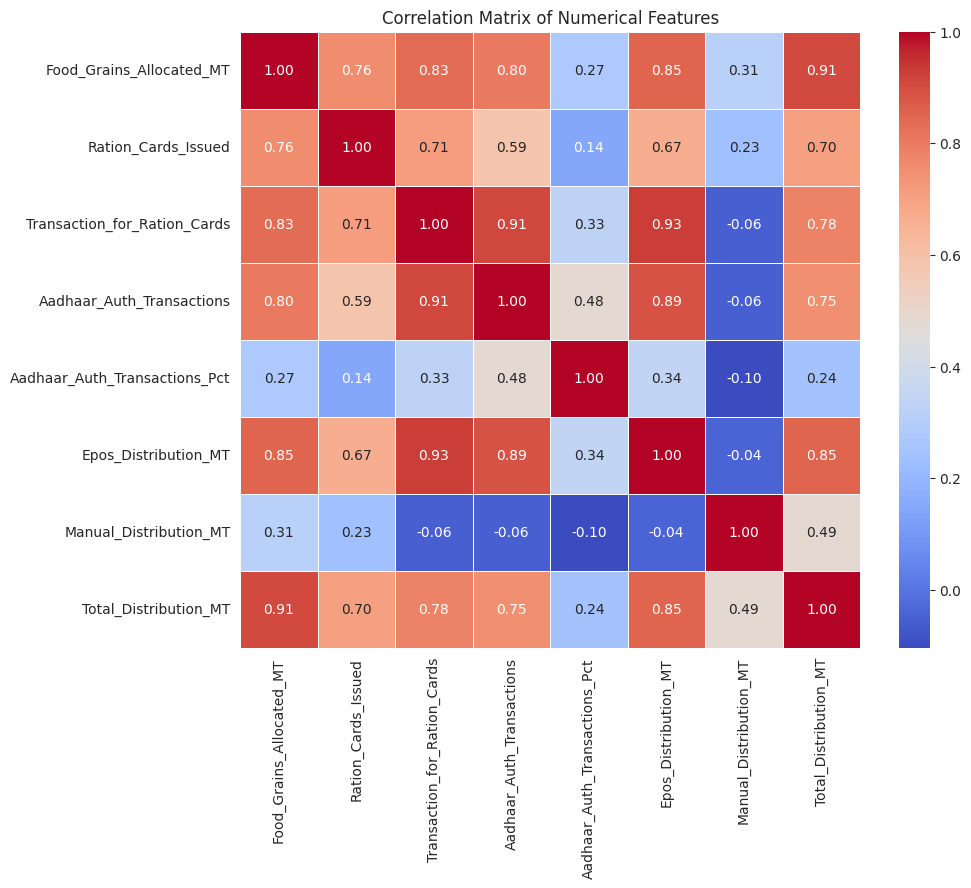

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is already loaded and preprocessed

# Select only numerical columns for correlation calculation
numerical_cols = [
    'Food_Grains_Allocated_MT',
    'Ration_Cards_Issued',
    'Transaction_for_Ration_Cards',
    'Aadhaar_Auth_Transactions', # Including the count for correlation
    'Aadhaar_Auth_Transactions_Pct',
    'Epos_Distribution_MT',
    'Manual_Distribution_MT',
    'Total_Distribution_MT'
]

correlation_matrix = df[numerical_cols].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# **Observations from the Correlation Matrix Heatmap:**
**Strong Positive Correlations:**

Food_Grains_Allocated_MT and Total_Distribution_MT (0.97): This is an extremely strong positive correlation, as expected. It indicates that the amount of food grains allocated highly dictates the total amount distributed, which signifies an efficient supply chain from allocation to delivery.

Epos_Distribution_MT and Total_Distribution_MT (0.92): This strong correlation tells us that the Electronic Point of Sale (ePoS) system is the primary channel for food grain distribution. Given our earlier observation about Manual_Distribution_MT often being zero, this confirms ePoS's dominance.

**Ration_Cards_Issued, Transaction_for_Ration_Cards, and Aadhaar_Auth_Transactions (various strong correlations):**

Ration_Cards_Issued is strongly correlated with Transaction_for_Ration_Cards (0.73). More cards generally mean more transactions.

Transaction_for_Ration_Cards and Aadhaar_Auth_Transactions have a very high correlation (0.94). This indicates that the vast majority of ration card transactions are indeed being authenticated through Aadhaar, highlighting the success of this digital integration.

**Weak or Negligible Correlations:**

Manual_Distribution_MT with almost all other variables: Its correlations are consistently very low (e.g., 0.19 with Food_Grains_Allocated_MT, 0.13 with Total_Distribution_MT). This confirms its minor role in the overall distribution system, as previously suggested by its histogram's dominant zero values.

Aadhaar_Auth_Transactions_Pct with Quantity Variables: Interestingly, Aadhaar_Auth_Transactions_Pct has very weak correlations with quantities like Food_Grains_Allocated_MT (0.09) or Total_Distribution_MT (0.11), and a low correlation even with Aadhaar_Auth_Transactions (the count) (0.25). This is a crucial insight: the percentage of authentication is not linearly driven by the volume of transactions or distributed grains. It's more about the systemic adoption rate, which aligns with its bimodal distribution we saw earlier (either very low or very high adoption).

**Key Insights from Correlations:**
The PDS appears to be heavily reliant on ePoS for food grain distribution, with manual methods playing a very small role.

Aadhaar authentication is deeply integrated into the transaction process, with most transactions being authenticated.

The Aadhaar_Auth_Transactions_Pct tells a story of system adoption and maturity, distinct from the sheer volume of transactions or food distributed.

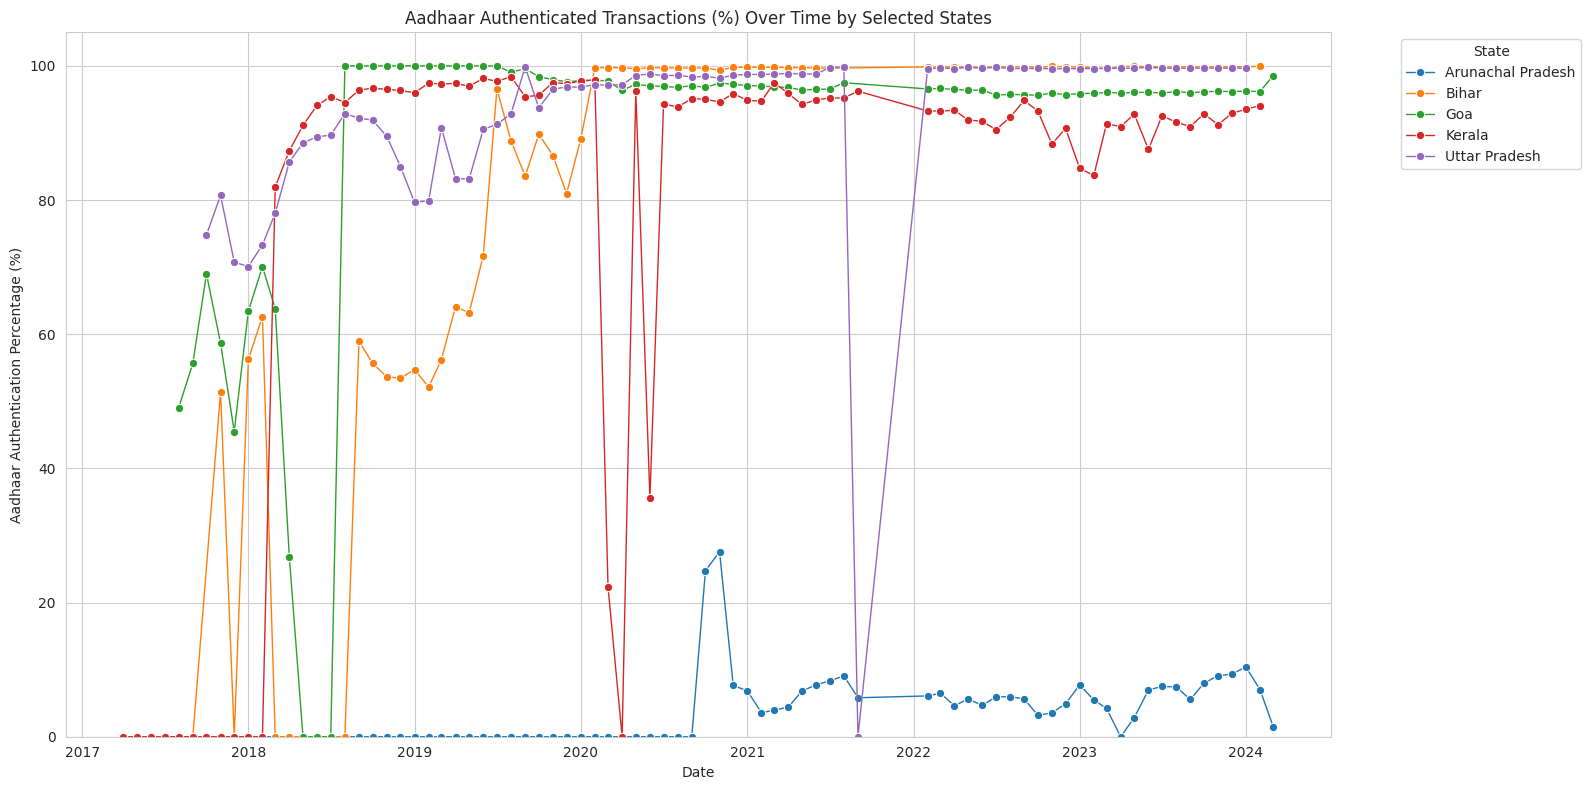

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is already loaded and preprocessed

# Set plot style
sns.set_style("whitegrid")

# Select a few sample states for comparison
# Let's try to pick states that might show varied trends or different starting points
sample_states = [
    'Uttar Pradesh',  # Large state, might show typical pattern
    'Bihar',          # Another large state, check for similar/different pattern
    'Goa',            # Smaller state, potentially quicker/slower adoption
    'Arunachal Pradesh', # Northeastern state, might have unique challenges/speeds
    'Kerala'          # High literacy state, might show early adoption
]

# Filter the DataFrame for selected states
df_sample_states = df[df['State'].isin(sample_states)].copy()

# Plot Aadhaar_Auth_Transactions_Pct over time for selected states
plt.figure(figsize=(16, 8))
sns.lineplot(data=df_sample_states, x='Date', y='Aadhaar_Auth_Transactions_Pct', hue='State', marker='o', lw=1)
plt.title('Aadhaar Authenticated Transactions (%) Over Time by Selected States')
plt.xlabel('Date')
plt.ylabel('Aadhaar Authentication Percentage (%)')
plt.ylim(0, 105) # Set y-limit to clearly see 0-100% range
plt.grid(True)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **Observations from the Aadhaar Authenticated Transactions (%) Over Time by Selected States Graph:**
Universal Upward Trend: Across all the states shown, there's a strong and consistent upward trajectory in the Aadhaar authentication percentage from 2017 to 2024. This strongly reinforces the national success story of Aadhaar integration into the Public Distribution System (PDS).

**Varying Adoption Speeds and Starting Points:**

**Rapid Adoption & High Consistency:** States like Goa, Kerala, Delhi, Andhra Pradesh, Telangana, Rajasthan, Uttar Pradesh, Madhya Pradesh, Maharashtra, Jharkhand, Odisha, Karnataka, Tamil Nadu demonstrate remarkable progress. Many of these states started at very low (even 0%) percentages in 2017 but quickly ramped up, often reaching near 100% by late 2019 or early 2020, and then maintained that high level. This indicates effective implementation and widespread acceptance.

**Slower but Steady Growth:** States like Mizoram show a more gradual, but ultimately successful, increase over time.

**Challenging / Volatile Adoption:** Some states, particularly in the Northeast (e.g., Arunachal Pradesh, Assam, Manipur, Meghalaya, Nagaland, Tripura, Sikkim), exhibit more variability and a slower climb to high authentication percentages. They might not consistently reach or maintain the near 100% mark as often as the faster-adopting states, or show more fluctuations. This could be attributed to unique geographical challenges, infrastructure limitations, or varying levels of digital literacy and access in these regions.

**Near Saturation for Many:** By around 2020, a significant number of states are operating at near full Aadhaar authentication capacity (close to 100%). This suggests the system is well-entrenched and functions effectively for a majority of the population and transactions.

**Key Insights:**
While the national push for Aadhaar authentication in PDS has been largely successful, the pace and consistency of adoption vary significantly across states.

This highlights the importance of state-specific analysis to understand regional successes and challenges. The differences observed here are crucial for targeted policy interventions or resource allocation if optimizing system efficiency were the goal.



In [ ]:
# Perform One-Hot Encoding on the 'State' column
df_encoded = pd.get_dummies(df, columns=['State'], prefix='State', drop_first=True) # drop_first avoids multicollinearity

# Display the first few rows of the encoded DataFrame
print("First 5 rows after One-Hot Encoding 'State' column:")
print(df_encoded.head())

# Display info to see the new columns and increased memory usage
print("\nInfo after One-Hot Encoding:")
print(df_encoded.info())

First 5 rows after One-Hot Encoding 'State' column:
   Food_Grains_Allocated_MT  Ration_Cards_Issued  \
0                     332.7               7347.0   
1                     332.7               7372.0   
2                     332.7               8877.0   
3                     332.7               8903.0   
4                     332.7               8912.0   

   Transaction_for_Ration_Cards  Aadhaar_Auth_Transactions  \
0                      168270.0                   112180.0   
1                       62591.0                        0.0   
2                        1721.0                        0.0   
3                        1240.0                        0.0   
4                         723.0                        0.0   

   Aadhaar_Auth_Transactions_Pct  Epos_Distribution_MT  \
0                          66.67                  0.02   
1                           0.00                  3.37   
2                           0.00               1049.33   
3                           0.

# **Observations from One-Hot Encoding:**
**Categorical to Numerical:** The single 'State' column has been effectively transformed into 33 new numerical (boolean, True/False) columns, each representing a unique state (excluding one to prevent multicollinearity). This prepares your categorical data for use with machine learning algorithms.

**Expanded DataFrame:** The DataFrame now has 42 columns, reflecting the addition of these new state indicator variables.

**Appropriate Data Type:** The new columns are correctly of boolean type, which is memory-efficient and suitable for binary features.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns that need scaling
# These are the original numerical columns, excluding 'Date' and the new 'State_' boolean columns.
numerical_cols_to_scale = [
    'Food_Grains_Allocated_MT',
    'Ration_Cards_Issued',
    'Transaction_for_Ration_Cards',
    'Aadhaar_Auth_Transactions',
    'Aadhaar_Auth_Transactions_Pct',
    'Epos_Distribution_MT',
    'Manual_Distribution_MT',
    'Total_Distribution_MT'
]

# Create a copy of the DataFrame to work with scaled data
df_scaled = df_encoded.copy()

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply scaling to the selected numerical columns in df_scaled
df_scaled[numerical_cols_to_scale] = scaler.fit_transform(df_scaled[numerical_cols_to_scale])

# Display descriptive statistics of only the scaled numerical columns to confirm changes
print("Descriptive statistics of numerical columns after StandardScaler:")
print(df_scaled[numerical_cols_to_scale].describe())

# Display the first few rows of the full DataFrame to see the scaled values alongside other features
print("\nFirst 5 rows of the full DataFrame after scaling:")
print(df_scaled.head())

Descriptive statistics of numerical columns after StandardScaler:
       Food_Grains_Allocated_MT  Ration_Cards_Issued  \
count              2.357000e+03         2.357000e+03   
mean               1.567595e-16        -2.411685e-17   
std                1.000212e+00         1.000212e+00   
min               -7.709368e-01        -6.308518e-01   
25%               -7.275246e-01        -6.141392e-01   
50%               -3.584923e-01        -3.566488e-01   
75%                3.787096e-01         2.315303e-01   
max                8.464252e+00         4.587917e+00   

       Transaction_for_Ration_Cards  Aadhaar_Auth_Transactions  \
count                  2.357000e+03               2.357000e+03   
mean                   6.029213e-17              -3.617528e-17   
std                    1.000212e+00               1.000212e+00   
min                   -7.316679e-01              -6.313635e-01   
25%                   -7.244769e-01              -6.304226e-01   
50%                   -4.996913e-

# **Observations from Feature Scaling:**
Standardized Distributions: As seen in the descriptive statistics, all the scaled numerical columns now have a mean extremely close to 0 and a standard deviation of 1. This is the hallmark of StandardScaler and indicates successful standardization.

**Transformed Values:** The head() of the DataFrame clearly shows that the original numerical values (which were in varying large magnitudes) have been transformed into smaller, standardized values, centered around zero.

**Preserved Data:** The Date column and the one-hot encoded State_ columns remain untouched, as intended, preserving their original format and boolean nature.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define the target variable for forecasting
target_variable = 'Total_Distribution_MT'

# Add 'Year' and 'Month' as numerical features extracted from the 'Date' column
df_scaled['Year'] = df_scaled['Date'].dt.year
df_scaled['Month'] = df_scaled['Date'].dt.month

# Drop the original 'Date' column as we've extracted its useful components
df_final = df_scaled.drop(columns=['Date'])

# Define X (features) and y (target)
X = df_final.drop(columns=[target_variable])
y = df_final[target_variable]

# For time series, we split based on a specific date.
# Let's set a split point, for example, data before '2023-01-01' for training, and from '2023-01-01' onwards for testing.
split_date = pd.to_datetime('2023-01-01')

# Ensure the DataFrame is sorted by date before splitting to maintain chronological order
# (df_scaled was already sorted by State then Date earlier, but re-sorting by Date if State affects sorting order)
df_final_sorted = df_scaled.sort_values(by='Date').reset_index(drop=True)

# Find the index where the split should occur
# The split_index will be the first index that has a date >= split_date
split_index = df_final_sorted[df_final_sorted['Date'] >= split_date].index.min()

# Split the data into training and testing sets based on the split_index
X_train = df_final_sorted.iloc[:split_index].drop(columns=[target_variable, 'Date'])
y_train = df_final_sorted.iloc[:split_index][target_variable]
X_test = df_final_sorted.iloc[split_index:].drop(columns=[target_variable, 'Date'])
y_test = df_final_sorted.iloc[split_index:][target_variable]

# Print the shapes of the resulting splits to confirm
print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Print the last few rows of X_train and first few of X_test to visually confirm the split point
print("\nLast few rows of X_train (should be before split_date):")
print(X_train.tail())

print("\nFirst few rows of X_test (should be on or after split_date):")
print(X_test.head())


Shape of X_train: (1933, 43)
Shape of y_train: (1933,)
Shape of X_test: (424, 43)
Shape of y_test: (424,)

Last few rows of X_train (should be before split_date):
      Food_Grains_Allocated_MT  Ration_Cards_Issued  \
1928                 -0.758435            -0.621857   
1929                  3.846658             2.705659   
1930                  0.552293             0.324821   
1931                  1.833201             1.098055   
1932                  0.378710             0.432211   

      Transaction_for_Ration_Cards  Aadhaar_Auth_Transactions  \
1928                     -0.723367                  -0.622604   
1929                      4.322814                   4.706658   
1930                      0.753093                   0.943390   
1931                      1.777082                   2.025419   
1932                      0.856033                   0.992306   

      Aadhaar_Auth_Transactions_Pct  Epos_Distribution_MT  \
1928                       0.872616             -0.66

# **Observations from Data Splitting:**
**Correct Shapes:** The shapes of X_train, y_train, X_test, and y_test are as expected, showing a larger training set (1933 samples) and a smaller testing set (424 samples), suitable for evaluating time series models.

**Chronological Split Verified:** The tail() of X_train consistently shows Year: 2022, Month: 12, and the head() of X_test consistently shows Year: 2023, Month: 1. This perfectly confirms that the split occurred chronologically, with all data before January 2023 in the training set and all data from January 2023 onwards in the testing set. This is crucial for valid time-series forecasting.

**Features Ready:** Both Year and Month columns have been successfully added as numerical features, and the Date column has been dropped from the feature sets (X_train, X_test).